# Convolutional Neural Networks and CIFAR10 Dataset

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.

Original versions were created by Ben Sattelberg and Asa Ben-Hur with updates by Ross Beveridge.

Last Update 11/16/20201

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras

from sklearn.metrics._plot import confusion_matrix as cm

import tensorflow as tf
from tensorflow.keras import datasets, layers, models


In this notebook, we'll look at a more challenging object recognition task captured by the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset is available directly through keras.

Later in this notebook when we reach convolutional neural networks the example model comes from [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)

There are some other resources you will want to review. For example, the site [How to Develop a CNN From Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)

# Introduction

What this notebook does very well is provide a sequence of machine learning models and demonstrate in miniature somewhat the progression of techniques for solving object recognition tasks.  These models are:

- ML Model 1: Linear Model
- ML Model 2: Dense Neural Network with 1 Hidden Layer
- ML Model 3: Dense Neural Network iwth 2 Hidden Layer
- ML Model 4: Convolutional Neural Network

What this notebook does badly is actually explain what a Convolutional Neural Network is and how it operates. To makeup for that failing, it is strongly recommended you go and, at a bare minimum, review [Convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) on Wikipedia.  And to be clear, this may not be enough of an introduction - but it is a very good quick jumping off point. 

Also, the internet has a tremendous abundance of excellent discussions and presentations from some of the people who created the deep learning computer vision revolutions.  Without any attempt at being exhaustive, here are a few to consider:

- [Introducing convolutional neural networks: ML Zero to Hero - Part 3](https://youtu.be/x_VrgWTKkiM)

- [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

- [Yann LeCun: Deep Learning, ConvNets, and Self-Supervised Learning | Lex Fridman Podcast #36](https://youtu.be/SGSOCuByo24)

# The CIFAR10 Dataset

In [2]:
# This will download an 11.5 MB file to ~/.keras/datasets/
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

Let's get some information about the dataset:

In [3]:
print(X_train.shape, y_train.shape)
print(min(y_train), max(y_train))

(50000, 32, 32, 3) (50000, 1)
[0] [9]


This tells that we have 50,000 training images, each of which is 32x32 pixels.  The labels are defined as follows:

- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck

It will be handy to load these labels into a dictionary

In [4]:
labels = np.array(["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"])

In [5]:
print(X_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 1)


Here we have 10,000 test with the same format as the training set. Here is the display of an example image.  Please keep in mind how much is being done for us by `imshow` including the correct guess that we are displaying a red, green, blue encoded color image.  

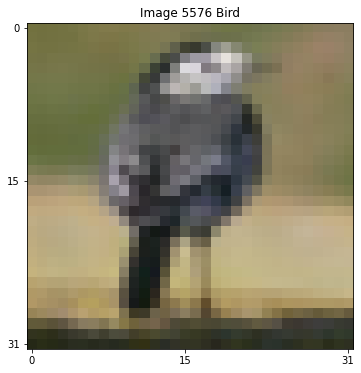

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
# pick = 1024 # A Bird
# pick = 256 # A horse
pick = 4576 + 1000
im = ax.imshow(X_train[pick])
ax.set_title('Image ' + str(pick) + ' ' + labels[y_train[pick,0]])
ax.set_xticks([0, 15, 31])
ax.set_yticks([0, 15, 31]);

Here we can see that the image is a grayscale 32 x 32 image with pixel values between 0 and 255.  We can also look at a few other images in the dataset:

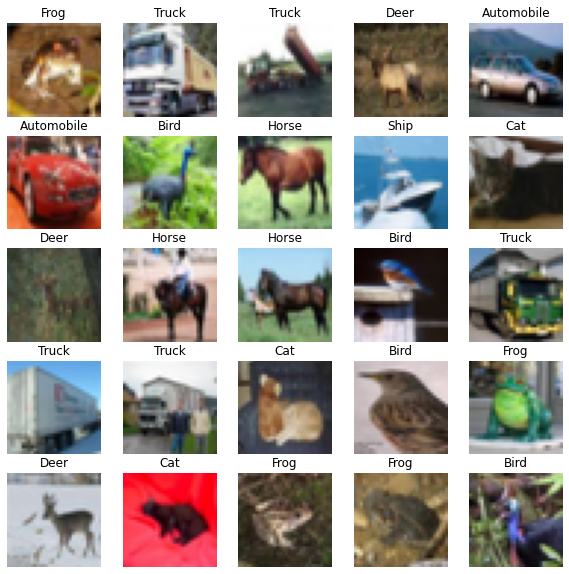

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(5):
    for j in range(5):
        axes[i,j].imshow(X_train[i*5 + j])
        axes[i,j].set_title(labels[y_train[i*5+j,0]])
        axes[i,j].axis('off')

# Dataset Proprocessing

There are a few things we want to do to the input data before we use it.  The first is to convert it to 32 bit floats:

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

We also want to change the range of the data from integers between 0 and 255 to numbers between 0 and 1 to help with training:

In [9]:
X_train /= 255
X_test /= 255

The last step, which is less obvious, is to reshape the actual data to have an extra dimension:

This dimension corresponds to the number of "channels" in the image.  This data is grayscale, but color images are typically stored in RGB (red, green, blue) format, where there the three channels describe the amount of red, green, and blue at each pixel.  Keras is designed to handle images as a native data format without needing to "flatten" the images into vectors as a preprocessing step.

We will also convert the `y_train` and `y_test` to a one-hot encoding:

In [10]:
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

# ML Model 1: Linear

The first experiment we will do with this dataset is to test a simple linear model to get a baseline for how good we can expect our models to be.  We will use Keras for this, and simply not have any hidden layers in our network.

Let us be clear, unlike our previous example with the MNIST Digits dataset, we are not expecting a linear model to do particularly well on CIFAR10. However - and this is good general rule - when faced with a new machine learning task, do not simply **guess** that simple methods will fail: test them.

In addition to the accuracy on the training set, we want to keep track of the accuracy on the testing set.  One way to do this with Keras is with a callback function that keeps track of the accuracy on the testing set as we progress through it.  It isn't necessary to understand the code here, but it is good to be aware of the goal of this structure.

In [11]:
# Structure based on https://github.com/keras-team/keras/issues/2548
class EvaluateCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        if 'test loss' not in logs:
            logs['test loss'] = []
            logs['test acc'] = []
        logs['test loss'] += [loss]
        logs['test acc'] += [acc]
        print('Testing loss: {}, acc: {}\n'.format(round(loss, 4), round(acc, 4)))
    

We can now train our model.  One layer to notice is the ```Flatten()``` layer.  This layer converts the data from a 32x32x3 dimensional image to a 3072=32\*32\*3 dimensional vector.

## Build the Linear Model

Note carefully the simplicity of building a linear model using the keras API.  Maybe just as important, recognize that a single layer (no hidden layer) neural network is with the correct configuration, nothing more than a set of linear classifers.

In [12]:
linear_model = keras.Sequential(name="Linear")
linear_model.add(keras.layers.Flatten())
linear_model.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

## Train the Linear Model

Pay attention the information presented during training, namely the accuracy on the training set and the test set. Also notice the model summary at the end and particularly the number of trainable parameters.

In [13]:
epochs_n_linear = 10 
linear_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
linear_history = linear_model.fit(X_train, y_train_one_hot, 
                                  batch_size=500, epochs=epochs_n_linear, 
                                  verbose=1, callbacks=[EvaluateCallback((X_test, y_test_one_hot))])
linear_model.summary()

Epoch 1/10
100/100 [==============================] - 2s 11ms/step - loss: 2.1920 - accuracy: 0.2158
Testing loss: 1.8838, acc: 0.3334

Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 1.8645 - accuracy: 0.3469
Testing loss: 1.8375, acc: 0.3557

Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 1.8203 - accuracy: 0.3667
Testing loss: 1.8086, acc: 0.3708

Epoch 4/10
100/100 [==============================] - 1s 12ms/step - loss: 1.7939 - accuracy: 0.3767
Testing loss: 1.7915, acc: 0.3746

Epoch 5/10
100/100 [==============================] - 1s 8ms/step - loss: 1.7787 - accuracy: 0.3855
Testing loss: 1.7818, acc: 0.3802

Epoch 6/10
100/100 [==============================] - 1s 9ms/step - loss: 1.7646 - accuracy: 0.3925
Testing loss: 1.7725, acc: 0.3847

Epoch 7/10
100/100 [==============================] - 1s 9ms/step - loss: 1.7613 - accuracy: 0.3905
Testing loss: 1.7522, acc: 0.3904

Epoch 8/10
100/100 [==============================] 

In [14]:
def print_loss_and_acc(X_test, y_test_one_hot, model) :
    foo = model.evaluate(X_test, y_test_one_hot, verbose=0)
    print(f'Final loss: {foo[0]:6.4f}, Test accuracy: {foo[1]:4.2f}')

print_loss_and_acc(X_test, y_test_one_hot, linear_model)

Final loss: 1.7541, Test accuracy: 0.39


We can also look at the accuracy over the epochs of the network:

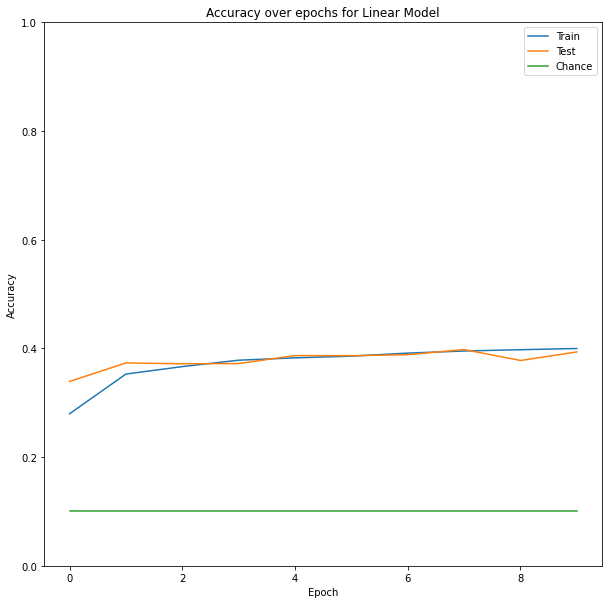

In [15]:
def plot_history(hist, title) :
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.plot(hist.history['accuracy'], label='Train')
    ax.plot(hist.history['test acc'], label='Test')
    ax.plot([0.1] * len(hist.history['accuracy']), label='Chance')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_ylim([0.0,1.0])
    ax.set_title("Accuracy over epochs for " + title)
    
plot_history(linear_history, "Linear Model")

Even though the result of a linear classifier is not something to get excited about, it is **important** to notice what is being taught to us about our data.  First, always ask yourself what is the chance baseline. Notice it is included on the plot above for emphasis.  The linear classifier is getting a correct answer about 3 in 10 times when chance is 1 in 10 times.  That alone tells us that for at least some cases the distinctions between classes can be uncovered by even a very simple machine learning model. 

Now, another message that comes through is how quickly the generalization to the test data falls apart.  Clearly more training epochs are not helping.  Examining these plots of accuracy versus epock to see if/when additional training is of little or no value is one of those human activities which you will carry out when applying models to new datasets. 

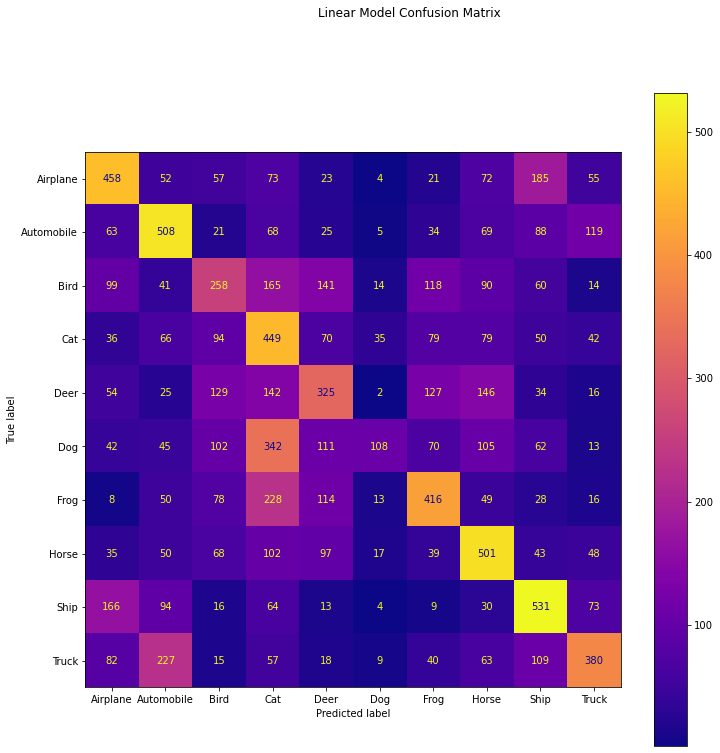

In [16]:
def conf_matrix_display(model, labels, title) :
    y_test_pred = np.argmax(model.predict(X_test),axis=1)
    matrix = cm.confusion_matrix(y_test, y_test_pred)
    disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax, include_values=True, values_format='', cmap=plt.cm.plasma)
    fig.suptitle(title)
    
conf_matrix_display(linear_model, labels, "Linear Model Confusion Matrix")

# ML Model 2:  One Hidden Layer

Now let's train a more interesting neural network on this problem.  We'll start with a single hidden layer with 256 nodes:

## Build the One Hidden Layer Model

Notice the width is a architecture - rather than learned - parameter.

In [17]:
h1_width = 256
network_h1 = keras.Sequential(name="Network_h1")
network_h1.add(keras.layers.Flatten())
network_h1.add(keras.layers.Dense(h1_width, activation='relu'))
network_h1.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

## Train and Summarize the Model

In [18]:
network_h1_epochs = 10 
network_h1.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
history = network_h1.fit(X_train, y_train_one_hot, batch_size=500, epochs=network_h1_epochs, verbose=1, 
                         callbacks=[EvaluateCallback((X_test, keras.utils.to_categorical(y_test, 10)))])
network_h1.summary()

Epoch 1/10
50000/50000 [==============================] - 2s 34us/step - loss: 2.0580 - accuracy: 0.2807
Testing loss: 1.865, acc: 0.3374

Epoch 2/10
50000/50000 [==============================] - 2s 33us/step - loss: 1.8082 - accuracy: 0.3627
Testing loss: 1.7578, acc: 0.3816

Epoch 3/10
50000/50000 [==============================] - 2s 34us/step - loss: 1.7438 - accuracy: 0.3863
Testing loss: 1.731, acc: 0.3903

Epoch 4/10
50000/50000 [==============================] - 2s 34us/step - loss: 1.6984 - accuracy: 0.4025
Testing loss: 1.6748, acc: 0.408

Epoch 5/10
50000/50000 [==============================] - 2s 34us/step - loss: 1.6717 - accuracy: 0.4128
Testing loss: 1.6638, acc: 0.4133

Epoch 6/10
50000/50000 [==============================] - 2s 34us/step - loss: 1.6375 - accuracy: 0.4269
Testing loss: 1.6651, acc: 0.4059

Epoch 7/10
50000/50000 [==============================] - 2s 34us/step - loss: 1.6067 - accuracy: 0.4368
Testing loss: 1.6154, acc: 0.4339

Epoch 8/10
50000/50000 

In [19]:
print_loss_and_acc(X_test, y_test_one_hot, network_h1)

Final loss: 1.5584, Test accuracy: 0.45


The total number of parameters for this network is more than an order of magnitude higher than the linear model.  It is doing a bit better than the linear model, which we really did not expect to work very well, but getting the correct answer 45 out of 100 times is still not very good.

The network also reaches only 50% accuracy on the training set.

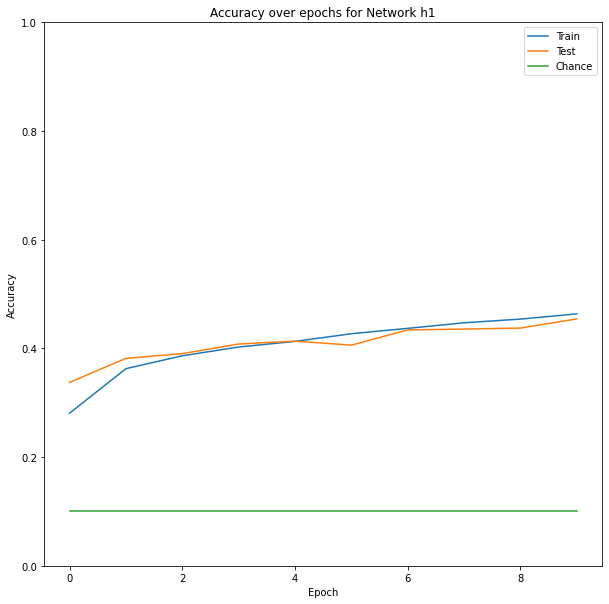

In [20]:
plot_history(history, "Network h1")

Since there's the potential to overfit, and a large number of parameters, simply increasing the depth or the width of this network could potentially lead to issues. 

Again, as with the linear model, it is worthwhile looking at the confusion matrix to see if there are classes being better recongized than others using the single hidden layer fully connected network.

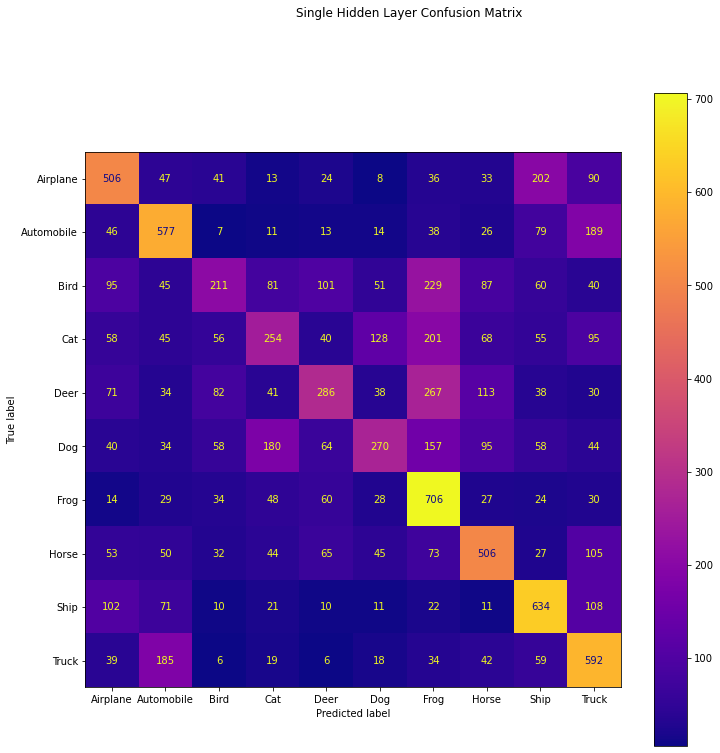

In [21]:
conf_matrix_display(network_h1, labels, "Single Hidden Layer Confusion Matrix")

# ML Model 3: Two Hidden Layers

Please do not consider this a terribly good idea - but for the sake of illustration - let us consider what happens if we add another hidden layer the same width as the first.

## Build the Two Layer Model

In [22]:
h2_width = 256
network_h2 = keras.Sequential(name="Network_h2")
network_h2.add(keras.layers.Flatten())
network_h2.add(keras.layers.Dense(h2_width, activation='relu'))
network_h2.add(keras.layers.Dense(h2_width, activation='relu'))
network_h2.add(keras.layers.Dense(10, activation='softmax'))
loss_fn = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()

In [23]:
network_h2_epochs = 10 
network_h2.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
history = network_h2.fit(X_train, y_train_one_hot, batch_size=500, epochs=network_h2_epochs, verbose=1, 
                         callbacks=[EvaluateCallback((X_test, keras.utils.to_categorical(y_test, 10)))])
network_h2.summary()

Epoch 1/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.9682 - accuracy: 0.2909
Testing loss: 1.8109, acc: 0.3602

Epoch 2/10
50000/50000 [==============================] - 2s 36us/step - loss: 1.7574 - accuracy: 0.3752
Testing loss: 1.7102, acc: 0.3934

Epoch 3/10
50000/50000 [==============================] - 2s 37us/step - loss: 1.6719 - accuracy: 0.4061
Testing loss: 1.6306, acc: 0.4188

Epoch 4/10
50000/50000 [==============================] - 2s 38us/step - loss: 1.6062 - accuracy: 0.4286
Testing loss: 1.5794, acc: 0.4412

Epoch 5/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.5583 - accuracy: 0.4471
Testing loss: 1.6, acc: 0.4223

Epoch 6/10
50000/50000 [==============================] - 2s 39us/step - loss: 1.5195 - accuracy: 0.4600
Testing loss: 1.5298, acc: 0.4597

Epoch 7/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.4954 - accuracy: 0.4693
Testing loss: 1.5038, acc: 0.465

Epoch 8/10
50000/50000 [

In [24]:
print_loss_and_acc(X_test, y_test_one_hot, network_h2)

Final loss: 1.4671, Test accuracy: 0.48


Notice two things.  The actual increase in the number of parameters was not that great. The increase in performance was also not great. 

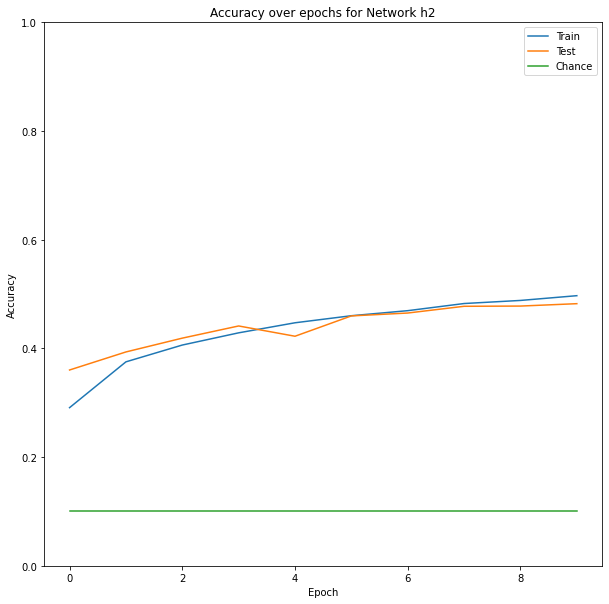

In [25]:
plot_history(history, "Network h2")

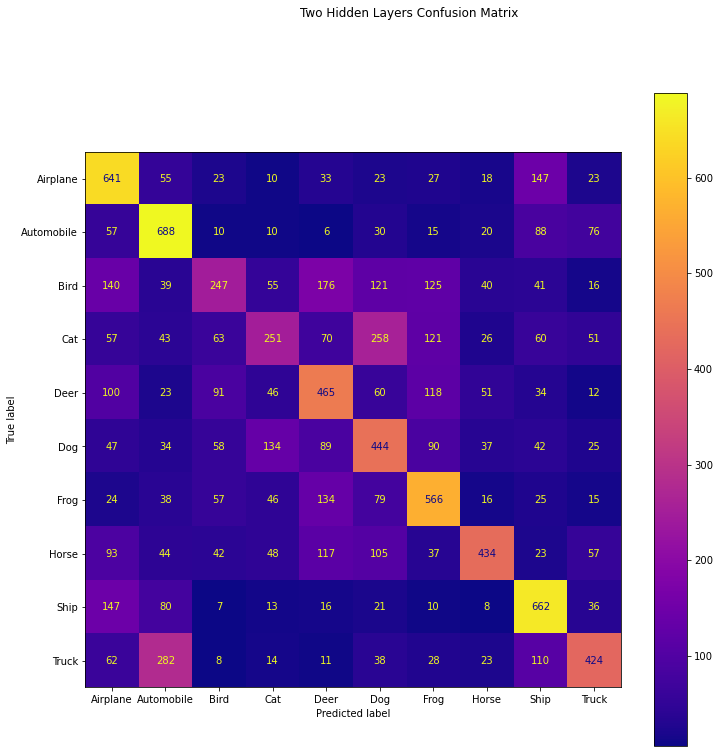

In [26]:
conf_matrix_display(network_h2, labels, "Two Hidden Layers Confusion Matrix")

## Limits to Just Adding Layers

As we've demonstrated, just adding layers does not really help much.  The best that can be said about the fully connected 2 layer network is that it gets the right answer for Airplanes, Automobiles, Birds, Horses, Ships and Trucks just over half the time.  Much better than chance, but still not really useful.

At the risk of gross over simplification, this would have been and example of why neural networks were not used much for object recognition until one more big advance came forward - the concept of convolutional layers. 

# Convolutional Neural Networks (CNNs)

As we've already said multiple times in this class, the convolutional neural network was one of the two to three elements of the modern machine learning revolution in pattern recognition; in partiicular when working with visual data (images).  To understand CNNs requires first an introduction image convolution, a truly elemetal operation in image processing.  Since the web is full of useful online resources to motivate and explain image convolution, let us here provide a recommended glimpse into these resources.

- [Convolutions in image processing | Week 1 | MIT 18.S191 Fall 2020 | Grant Sanderson](https://youtu.be/8rrHTtUzyZA). In particular the video illustration of convolving an image with a smoothing kernel in the first 10 minutes will hopefully bring the process of convolution to life for you.

- [Image Convolution Playground](https://generic-github-user.github.io/Image-Convolution-Playground/src/). This nice little interactive tool lets you see what happens when different convolutional masks, kernels, are applied to an image. 

After you have looked at these and in particular played with the interactive site hopefully the underlying concept of image convolution will feel if not obvious at least tangible. Last but not least, as you explore the code for the CNN presented below we recommend the following companion reading:

- [How to Visualize Filters and Feature Maps in Convolutional Neural Networks](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/). Here the topic is actually the kernels learned by a convolutional neural networks and so this presentation is by necessity somewhat complicated. That said, it is also very valuable in walking through the steps in a convolutional neural network focusing in particular on the features - kernels - that are learned.

# ML Model 4: CNN

Now on to the task of building and running a CNN and repeating from above the example here is drawn from the following tutorial: [Convolutional Neural Network (CNN)](https://www.tensorflow.org/tutorials/images/cnn)

Note that there are two convolutional layers each followed by a max pooling layer in the network being constructed and run here. 

## Build the CNN Model

In [27]:
network_cnn =  keras.Sequential(name="Network_CNN")
network_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
network_cnn.add(keras.layers.MaxPooling2D((2, 2)))
network_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
network_cnn.add(keras.layers.MaxPooling2D((2, 2)))
network_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
network_cnn.add(keras.layers.Flatten())
network_cnn.add(keras.layers.Dense(64, activation='relu'))
network_cnn.add(keras.layers.Dense(10))

## Train the CNN Model

In [28]:
network_cnn_epochs = 10
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
opt = keras.optimizers.Adam()

network_cnn.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

history = network_cnn.fit(X_train, y_train_one_hot, epochs=network_cnn_epochs, verbose=1, 
                         callbacks=[EvaluateCallback((X_test, keras.utils.to_categorical(y_test, 10)))])
network_cnn.summary()

Epoch 1/10
50000/50000 [==============================] - 26s 527us/step - loss: 1.4968 - accuracy: 0.4554
Testing loss: 1.1964, acc: 0.5792

Epoch 2/10
50000/50000 [==============================] - 29s 590us/step - loss: 1.1259 - accuracy: 0.6032
Testing loss: 1.0742, acc: 0.6183

Epoch 3/10
50000/50000 [==============================] - 30s 601us/step - loss: 0.9684 - accuracy: 0.6572
Testing loss: 0.9676, acc: 0.6603

Epoch 4/10
50000/50000 [==============================] - 32s 633us/step - loss: 0.8709 - accuracy: 0.6933
Testing loss: 0.9211, acc: 0.6828

Epoch 5/10
50000/50000 [==============================] - 31s 614us/step - loss: 0.7972 - accuracy: 0.7191
Testing loss: 0.8726, acc: 0.6984

Epoch 6/10
50000/50000 [==============================] - 31s 618us/step - loss: 0.7405 - accuracy: 0.7407
Testing loss: 0.8504, acc: 0.7051

Epoch 7/10
50000/50000 [==============================] - 32s 633us/step - loss: 0.6889 - accuracy: 0.7618
Testing loss: 0.8637, acc: 0.7051

Epoch 

In [29]:
print_loss_and_acc(X_test, y_test_one_hot, network_cnn)

Final loss: 0.8442, Test accuracy: 0.72


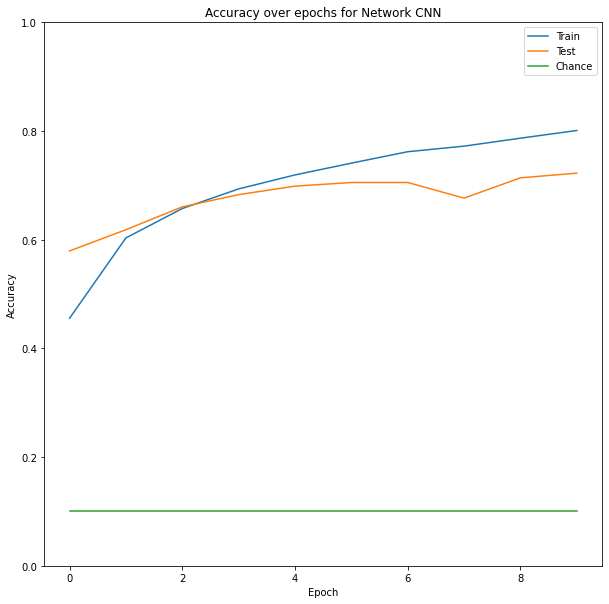

In [30]:
plot_history(history, "Network CNN")

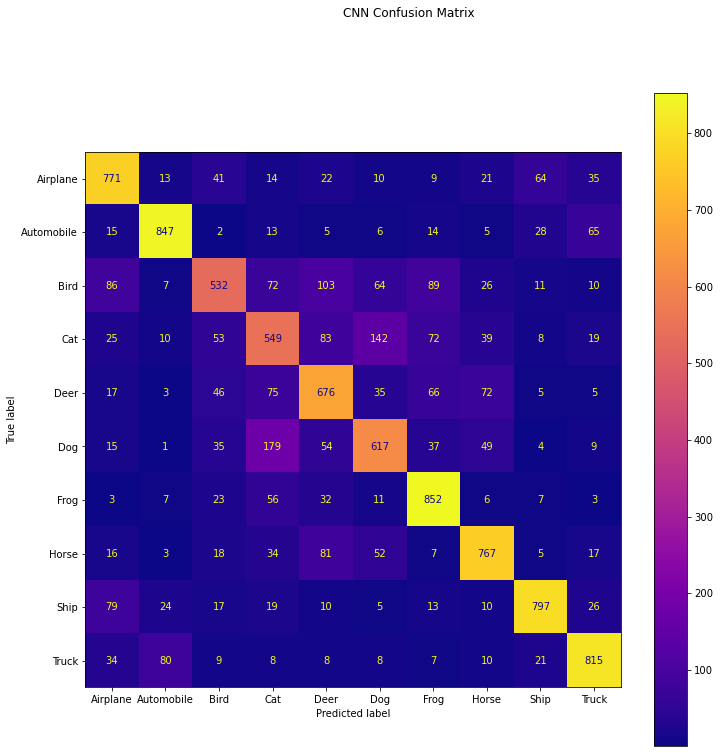

In [31]:
conf_matrix_display(network_cnn, labels, "CNN Confusion Matrix")

## CNNs and What Might Come Next

This is the point where CS345 essentially stops relative to top performing CNN approaches to object recognition.

From a practical standpoint, should you wish, you could review [How to Develop a CNN From Scratch for CIFAR-10 Photo Classification](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) and learn about such things as dropout, weight decay and data augmentation.  Put simply, there is more to be squeezed out of a CNN network with additional features, but you've seen already above the large boost associated with the convolutional layers tied to max pooling. 

# Summary

Here is a summary of the number of parameters and test accuracy of the four approaches


- ML Model 1: Linear Model: 30,730 / 0.39
- ML Model 2: Dense Neural Network with 1 Hidden Layer: 789,258 / 0.46
- ML Model 3: Dense Neural Network with 2 Hidden Layer: 855,050 / 0.51
- ML Model 4: Convolutional Neural Network: 122,570 / 0.71



# And a Bad Idea - Random Forest

Sometimes it is worth trying something difference, and of course sometimes it emphasizes why a certain approach is not appropriate.  So here we use the random forest classifier on CIFAR10 and the results are, well ...

In [32]:
X_train_flat = X_train.reshape(-1, 3072)
X_test_flat = X_test.reshape(-1, 3072)

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=8)
rf.fit(X_train_flat, y_train_one_hot);

In [34]:
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test_flat)
accuracy_score(y_pred, y_test_one_hot)

0.0894